<a href="https://colab.research.google.com/github/ahmadSoliman94/Machine-Learning/blob/main/DL/Modern%20Computer%20Vision%20with%20Pytorch/4.%20Object_Classification%2C_Detection_and_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introducing Convolutional Neural Networks:

### The problem with traditional deep neural network:

In [ ]:
from torchvision import datasets
import torch
data_folder = '/content/' # This can be any directory you want to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



In [ ]:
tr_images = fmnist.data
tr_targets = fmnist.targets

In [ ]:
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]        
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [ ]:
def get_data():     
    train = FMNISTDataset(tr_images, tr_targets)     
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)     
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl

In [ ]:
def val_loss(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


### Fetch a random image from the available training images: 

Text(0.5, 1.0, 'Trouser')

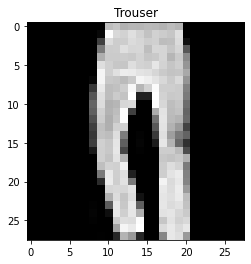

In [ ]:
# ix = np.random.randint(len(tr_images))
ix = 24300
plt.imshow(tr_images[ix], cmap='gray')
plt.title(fmnist.classes[tr_targets[ix]])

### Pass the image through the trained model:

In [ ]:
img = tr_images[ix]/255.
img = img.view(28*28)
img = img.to(device)

In [ ]:
np_output = model(img).cpu().detach().numpy()
np.exp(np_output)/np.sum(np.exp(np_output))


array([1.2751125e-03, 9.9862421e-01, 3.4044263e-07, 7.5510296e-05,
       4.9448208e-06, 3.7949057e-13, 1.9768091e-05, 6.8887098e-16,
       3.5549846e-08, 3.8645779e-12], dtype=float32)

 *Note: from the preceding output, we can see that the highst probbility is for the 1st index (Trouser class)*

### Translate (roll/slide) the image multiple times:

In [ ]:
tr_targets[ix]

tensor(1)

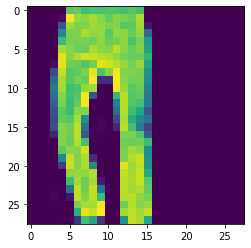

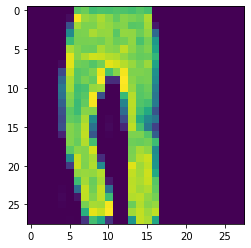

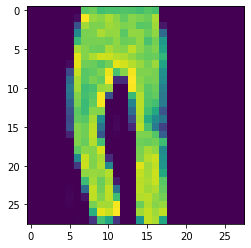

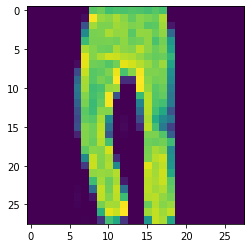

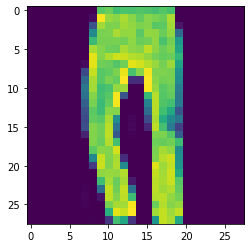

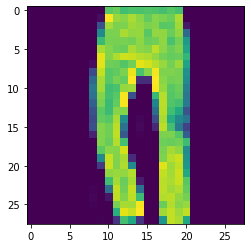

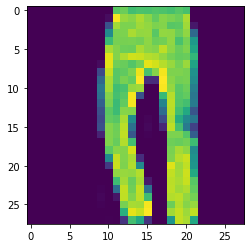

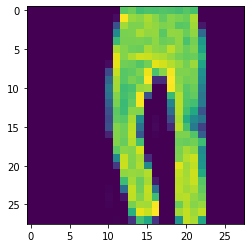

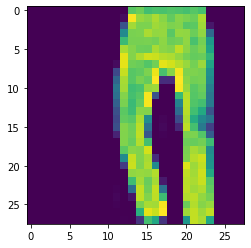

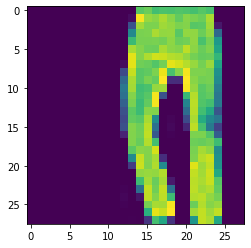

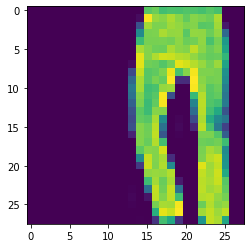

In [ ]:
preds = []
for px in range(-5,6):
  img = tr_images[ix]/255.
  img = img.view(28, 28)
  #img2 = np.zeros((28,28))
  img2 = np.roll(img, px, axis=1)
  plt.imshow(img2)
  plt.show()
  img3 = torch.Tensor(img2).view(28*28).to(device)
  np_output = model(img3).cpu().detach().numpy()
  preds.append(np.exp(np_output)/np.sum(np.exp(np_output)))

### Visualize the predictions of the model for all translations: 

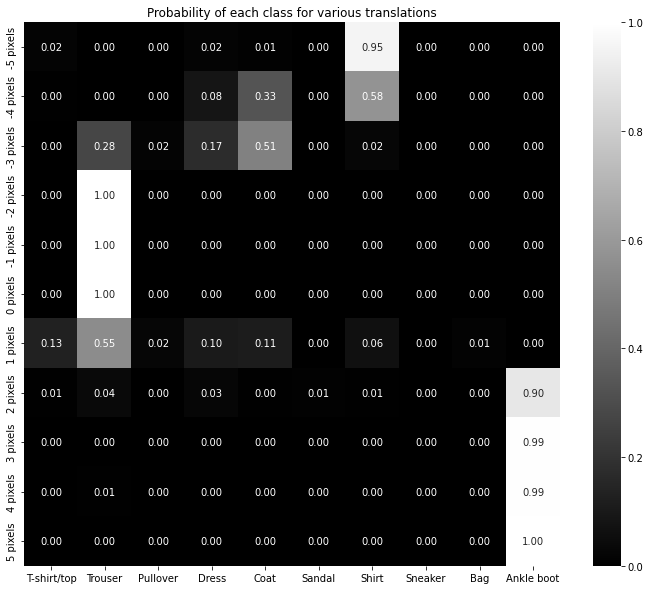

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)], cmap='gray')


*Note: A traditional neural network fails, when we made translations.*





### Building a CNN-bsed architecture using pytorch:

#### 1. First, need to import the relevant libraries:

In [ ]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.optim import SGD, Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 2. create the dataset:

In [ ]:
X_train = torch.tensor([[[[1,2,3,4],[2,3,4,5],[5,6,7,8],[1,3,4,5]]],[[[-1,2,3,-4],[2,-3,4,5],[-5,6,-7,8],[-1,-3,-4,-5]]]]).to(device).float()
X_train /= 8
y_train = torch.tensor([0,1]).to(device).float()

### 3. Define model architecture:

In [ ]:
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 1, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(1, 1),
        nn.Sigmoid(),
    ).to(device)
    loss_fn = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

### 4. Summarize the architecture of the model:

In [ ]:
!pip install torch_summary
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, X_train);

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 1, 2, 2]             10
├─MaxPool2d: 1-2                         [-1, 1, 1, 1]             --
├─ReLU: 1-3                              [-1, 1, 1, 1]             --
├─Flatten: 1-4                           [-1, 1]                   --
├─Linear: 1-5                            [-1, 1]                   2
├─Sigmoid: 1-6                           [-1, 1]                   --
Total params: 12
Trainable params: 12
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


### 5. train the model:

In [ ]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

#### - Define the training DataLoader:

In [ ]:
trn_dl = DataLoader(TensorDataset(X_train, y_train))

#### - Train the model:

In [ ]:
for epoch in range(100):
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)

ValueError: ignored

### Implementing data augmentation:

## 1. import the relevant libraries: 

In [1]:
%%capture
!pip install -U imgaug


In [2]:
import imgaug
print(imgaug.__version__)

0.4.0


In [3]:
import imgaug.augmenters as iaa

### 2. Download image from the trainig Dataset:

In [4]:
from torchvision import datasets
import torch
data_folder = '/content/' # This can be any directory you want to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



### 3. Fetch an image from the downloaded dataset: 

In [5]:
tr_images = fmnist.data
tr_targets = fmnist.targets

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def to_numpy(tensor):
    return tensor.cpu().detach().numpy()

### 4. plot the images:

Text(0.5, 1.0, 'Original image')

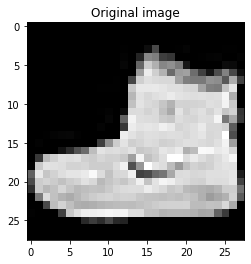

In [7]:
plt.imshow(tr_images[0], cmap='gray')
plt.title('Original image')

### 5. Perform scaling on top of the image:

Text(0.5, 1.0, 'Scaled image')

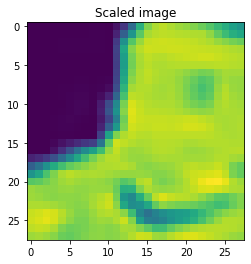

In [10]:
aug = iaa.Affine(scale=2)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])))
plt.title('Scaled image')

##### - Where an image has been translated:

Text(0.5, 1.0, 'Translated image by 10 pixels (right and bottom)')

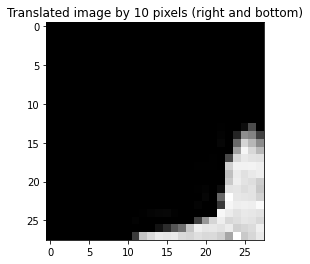

In [11]:
aug = iaa.Affine(translate_px=10)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Translated image by 10 pixels (right and bottom)')

### - Peform translation more in one axis ans less in the other axis: 

Text(0.5, 1.0, 'Translation of 10 pixels \nacross columns and 2 pixels over rows')

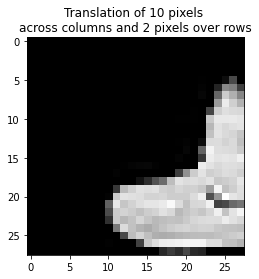

In [12]:
aug = iaa.Affine(translate_px={'x':10,'y':2})
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Translation of 10 pixels \nacross columns and 2 pixels over rows')

### - Impact of rotation and shearing:

Text(0.5, 1.0, 'Rotation of image by 30 degrees')

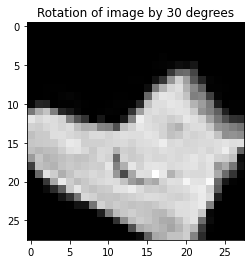

In [13]:
aug = iaa.Affine(rotate=30)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by 30 degrees')

Text(0.5, 1.0, 'Rotation of image by -30 degrees')

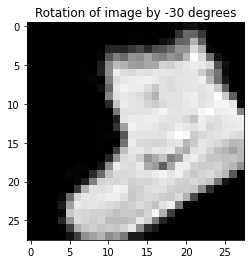

In [14]:
aug = iaa.Affine(rotate=-30)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by -30 degrees')

Text(0.5, 1.0, 'Shear of image by 30 degrees')

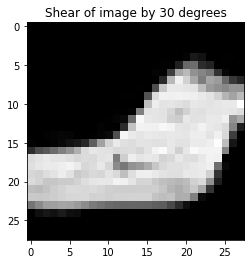

In [15]:
aug = iaa.Affine(shear=30)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Shear of image by 30 degrees')

Text(0.5, 1.0, 'Shear of image by -30 degrees')

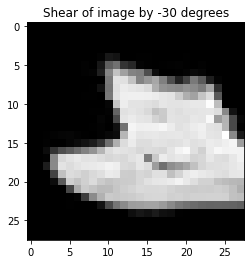

In [16]:
aug = iaa.Affine(shear=-30)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Shear of image by -30 degrees')

Text(0.5, 1.0, 'Shear of image \nby 30 degrees')

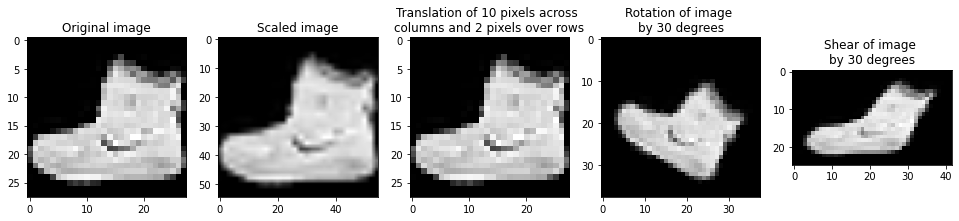

In [20]:
''' fit_output = True: help us not loss information'''

plt.figure(figsize=(20,20))
plt.subplot(161)
plt.imshow(tr_images[0], cmap='gray')
plt.title('Original image')
plt.subplot(162)
aug = iaa.Affine(scale=2, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Scaled image')
plt.subplot(163)
aug = iaa.Affine(translate_px={'x':10,'y':2}, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Translation of 10 pixels across \ncolumns and 2 pixels over rows')
plt.subplot(164)
aug = iaa.Affine(rotate=30, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image \nby 30 degrees')
plt.subplot(165)
aug = iaa.Affine(shear=30, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Shear of image \nby 30 degrees')

Text(0.5, 1.0, 'Rotation of image by 30 degrees')

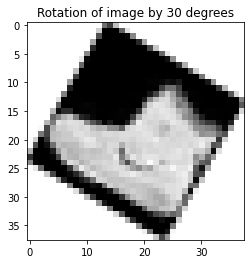

In [25]:
''' When the size of the augmented images increases(for example image rotated), we
need to figure out how the new pixels that are not part of  the orginal image should be filled in.
The cval parameter solves this issue.'''

aug = iaa.Affine(rotate=30, fit_output=True, cval=255) # the new pixels have benn filled with a pixel value of 255 -> (white).
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by 30 degrees')

Text(0.5, 1.0, 'Rotation of image by \n30 degrees with wrap mode')

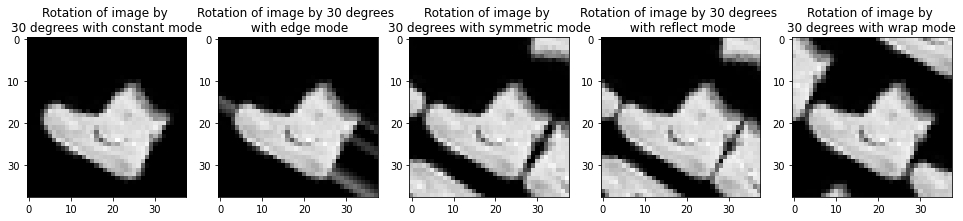

In [28]:
plt.figure(figsize=(20,20))
plt.subplot(161)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by \n30 degrees with constant mode')
plt.subplot(162)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='edge')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by 30 degrees \n with edge mode')
plt.subplot(163)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='symmetric')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by \n30 degrees with symmetric mode')
plt.subplot(164)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='reflect')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by 30 degrees \n with reflect mode')
plt.subplot(165)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='wrap')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by \n30 degrees with wrap mode')

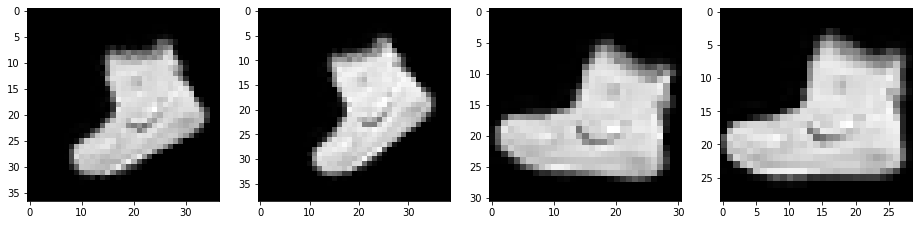

In [29]:
# for our dataset, it is more desirable to use constant mode for data agumentation.

plt.figure(figsize=(20,20))
plt.subplot(151)
aug = iaa.Affine(rotate=(-45,45), fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.subplot(152)
aug = iaa.Affine(rotate=(-45,45), fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.subplot(153)
aug = iaa.Affine(rotate=(-45,45), fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.subplot(154)
aug = iaa.Affine(rotate=(-45,45), fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')